<span style="color:blue">
    
## analysis of energy some price "day ahead prices" or DAM.
    
 There is also data labeled SIP which I believe is some measure of imbalance in supply and demand.
    
 I will focus on the DAM or Day ahead price data.

The goals here are
    1) Exploratory analysis to learn the features of the data
    2) Attemp one or two simple methods to predict the DAM series.
</span>

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from IPython.display import display

In [2]:
# read the file
file_path = os.path.join(".", "sip_dam_data.csv")
df = pd.read_csv(file_path, index_col=0)
display(df.head(2))

,SIP,DAM
2016-01-01 00:00:00,29.60,31.1
2016-01-01 00:30:00,48.14,31.1


In [3]:
# index looks like a datetime, so convert
df.index.name = "dt"
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

In [4]:
# check for nulls
nulldf = pd.DataFrame(df.isnull().sum())
nulldf.columns = ["#nulls"]
display(nulldf)
# can use the slices below to see where the nulls are
# they contiguous for both but on diffeent days
sipnull = df.loc[df["SIP"].isnull()]
damnull = df.loc[df["DAM"].isnull()]

,#nulls
SIP,35
DAM,6


In [5]:
# basic stats on the non null data
display(df.agg([np.min, np.mean, np.std, np.max]))

,SIP,DAM
amin,-153.890000,-38.800000
mean,44.300704,44.946502
std,42.136848,24.044061
amax,4000.000000,1500.000000


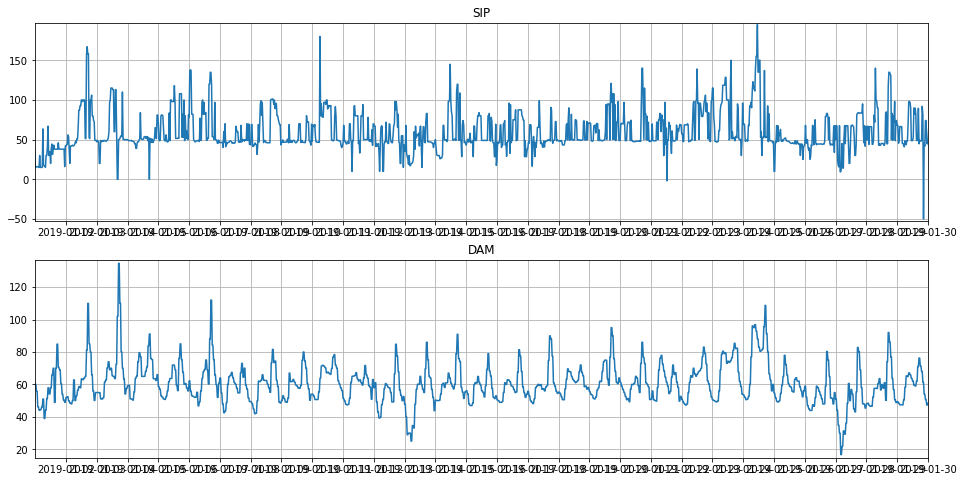

In [6]:
# plots to explore patterns
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[16, 8],)
pcols = ["SIP", "DAM"]
# use the start_dt and numdays to explore different
# parts of the series
# or set start_dt to null to see the full plot
start_dt = datetime.datetime(2019, 1, 1) 
#start_dt = None
if start_dt:
    numdays = 30
    xtick_freq = 1 # in days
    xticks = [start_dt + datetime.timedelta(days=x) for x in range(1, numdays, xtick_freq)]
    end_dt = max(xticks)
for i, (ax, col) in enumerate(zip(axs, pcols)):
    if start_dt:
        ax = axs[i]
        ax.set_xlim(start_dt, end_dt)
        ax.set_xticks(xticks,)
        ylim = df.loc[(df.index >= start_dt) & (df.index <= end_dt), col].agg([min, max])  
        ax.set_ylim([ylim[0]-2, ylim[1]+2])        
    ax.plot(df.index, df[pcols[i]],)
    ax.set_title(col)
    ax.grid()

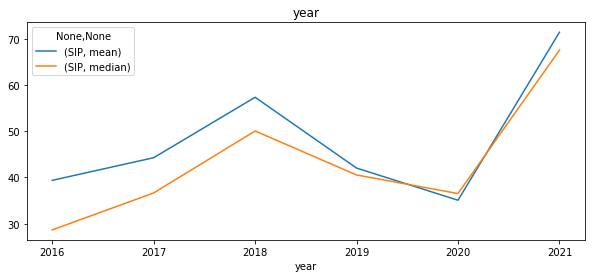

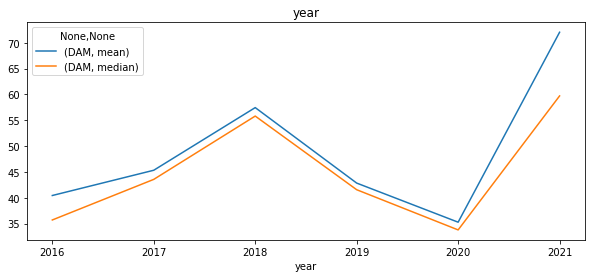

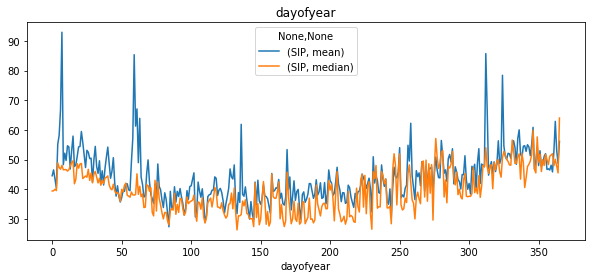

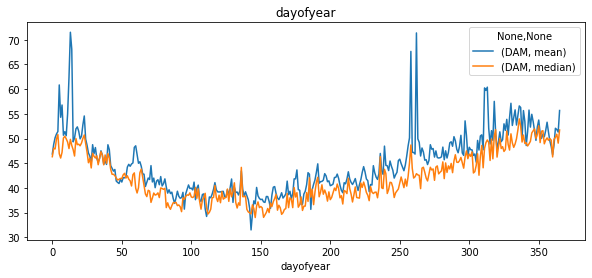

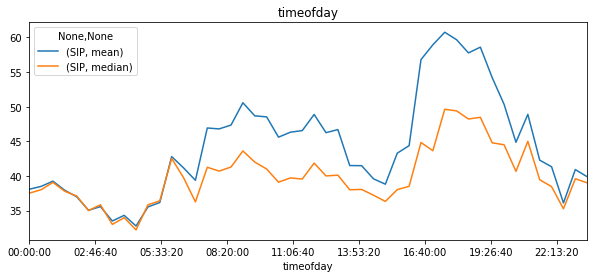

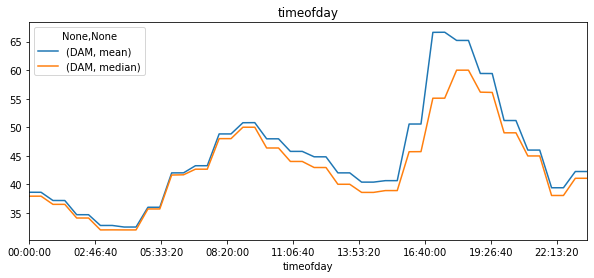

In [7]:
# Check to see if there are patterns in year,dayofyear or timeofday

df["dt"] = df.index
df["year"] = df["dt"].apply(lambda x: x.year)
df["dayofyear"] = df["dt"].apply(lambda x: (x - datetime.datetime(x.year, 1, 1)).days)
df["timeofday"] = df["dt"].apply(lambda x: (x - datetime.datetime(x.year, x.month, x.day)))
for window in ["year", "dayofyear", "timeofday"]:
    df[[window, "SIP"]].groupby(window).agg([np.mean, np.median]).plot(figsize=[10, 4], title=window)
    df[[window, "DAM"]].groupby(window).agg([np.mean, np.median]).plot(figsize=[10, 4], title=window)

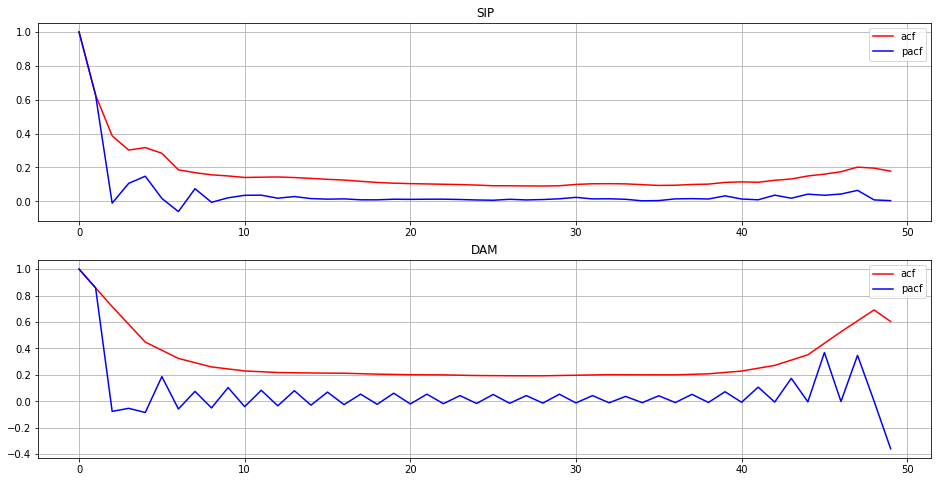

In [8]:
# Look at 2 standard time series metrics
#  ACF and PACF

pcols = ["SIP","DAM"]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[16, 8],)
for i, (ax, col) in enumerate(zip(axs, pcols)):
    notnull = df.loc[df[col].notnull()]
    acf = tsa.stattools.acf(notnull[col], )
    pacf = tsa.stattools.pacf(notnull[col])
    ax.plot(acf, color="red", label="acf")
    ax.plot(pacf, color="blue", label="pacf")
    ax.set_title(col)
    ax.grid()
    ax.legend()


<span style="color:blue">
    
##    Observations about the series

* There are short periods of missing data in both series
* There might be some differences in the levels over the years, it's a small sample to determine significance of this.
* Clear daily patterns in both SIP and DAM, more regular in DAM
    - 2 humps or spikes, one around 9 AM another around 5 PM
* Appears to be an annual pattern as well.  
    This seems odd as I would expect spring and fall to be similar
* The spikes in one often accompanied by spikes in the other
    - plenty of exceptions e.g. May 2017 spike in SIP
* The sawtooth pattern in the DAM PACF might be interesting
* The spike at 48 in the ACF of both is a daily pattern
* There might be useful information from one series
    that can be used to predict the other.

    </span>

<span style="color:blue">
    
## A simple predictive model
    
Now, let's build a few simple regression models to forecast 
1 day ahead values for DAM.

We will consider 3 models
1) using only dummies for the time of day  
2) same as #1 except add summary variables from the prev day DAM  
3) same as #2 except add summary variables for prev day SIP as well.  

We will compare the errors from the models to see if adding the DAM and SIP variables helps
    
 </span>

In [9]:
# Here we create the feature variables
# simply the min, max and sum over the last day
mm = df.copy()
for col in ["DAM", "SIP"]:
    mm[f"prevMin{col}"] = mm[col].rolling(48).min()
    mm[f"prevMax{col}"] = mm[col].rolling(48).max()
    mm[f"prevSum{col}"] = mm[col].rolling(48).sum()
    
# also create dummy variables for each half hour in the day
mm["tod"] = mm["timeofday"].apply(lambda x: str(x)[7:])
toddf = pd.get_dummies(mm.tod, prefix='TOD')
mm = mm.join(toddf)
mm.tail(2)

,SIP,DAM,dt,year,dayofyear,timeofday,prevMinDAM,prevMaxDAM,prevSumDAM,prevMinSIP,...,TOD_19:00:00,TOD_19:30:00,TOD_20:00:00,TOD_20:30:00,TOD_21:00:00,TOD_21:30:00,TOD_22:00:00,TOD_22:30:00,TOD_23:00:00,TOD_23:30:00
dt,,,,,,,,,,,,,,,,,,,,,
2021-02-16 23:30:00,7.00,39.8,2021-02-16 23:30:00,2021,46,0 days 23:30:00,32.0,77.8,2399.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2021-02-17 00:00:00,33.08,35.6,2021-02-17 00:00:00,2021,47,0 days 00:00:00,32.0,77.8,2398.4,0.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Function to do the rolling regression
def rmse(x, y):
    return (np.mean((x-y)**2))**.5

def mad(x, y):
    return (np.mean(np.abs(x-y)))



def rolling_predictions(mdf, xcols, ycol, start_dt, rolling_hist_days, end_dt):
    """ Do rolling regressions on a dataframe
    
    Input:
        mdf: pandas dataframe with all variables
        xcols: columns to use in prediction
        ycol: target column
        start_dt: start for the rolling regression
        rolling_hist_days: number of days to use for training
        end_dt: end for the rolling regression
    Notes: 
        - assuming the index is a datetime field
        - removing nulls from the data
           this could be an issue
    """
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False)
    mdf.dropna(how='any',axis=0, inplace=True)
    numdays = (end_dt - start_dt).days
    dates = [start_dt + datetime.timedelta(days=x) for x in range(numdays)]
    errs = []
    for train_end in dates:
        train_start = train_end - datetime.timedelta(days=rolling_hist_days)
        X_train = mdf.loc[(mdf.index >= train_start) & (mdf.index <= train_end), xcols].copy()
        y_train = mdf.loc[(mdf.index >= train_start) & (mdf.index <= train_end), ycol].copy()
        reg.fit(X_train, y_train)
        X_train.head(2)  
        test_end = train_end + datetime.timedelta(days=1)
        X_test = mdf.loc[(mdf.index > train_end) & (mm.index < test_end), xcols]
        y_test = mdf.loc[(mdf.index > train_end)& (mm.index < test_end), ycol]
        y_pred = reg.predict(X_test)   
        errs.append((train_end, rmse(y_test, y_pred), mad(y_test, y_pred)))
    errdf = pd.DataFrame(errs, columns=["train_end", "rmse", "mad"])
    return errdf


start_dt = datetime.datetime(2020,3,1)
end_dt = start_dt + datetime.timedelta(days=20)

ycol = "DAM"

# TOD ounly
xcols = [c for c in mm.columns if c.startswith("TOD")] 
errdf_tod = rolling_predictions(mdf=mm, xcols=xcols, ycol=ycol, 
                             start_dt=start_dt, rolling_hist_days=600, end_dt=end_dt)    
print(f"done with TOD {datetime.datetime.now()}")

# with DAM
xcols = [c for c in mm.columns if c.startswith("TOD")] + ["prevMinDAM", "prevMaxDAM", "prevSumDAM"]
errdf_dam = rolling_predictions(mdf=mm, xcols=xcols, ycol=ycol, 
                             start_dt=start_dt, rolling_hist_days=600, end_dt=end_dt)    
print(f"done with DAM {datetime.datetime.now()}")

xcols = [c for c in mm.columns if c.startswith("TOD")] + ["prevMinDAM", "prevMaxDAM", "prevSumDAM", 
                                                          "prevMinSIP", "prevMaxSIP", "prevSumSIP"]

# with DAM and SIP
errdf_sip = rolling_predictions(mdf=mm, xcols=xcols, ycol=ycol, 
                             start_dt=start_dt, rolling_hist_days=600, end_dt=end_dt)  
print(f"done with SIP {datetime.datetime.now()}")


done with TOD 2022-09-22 14:26:14.338008
done with DAM 2022-09-22 14:26:15.135160
done with SIP 2022-09-22 14:26:15.925875


/tmp/ipykernel_35931/2031366054.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  display(errdf.mean())


rmseDAM     7.797469
madDAM      6.423853
rmseSIP     7.756929
madSIP      6.379487
rmse       15.921617
mad        14.656429
dtype: float64

<AxesSubplot:xlabel='train_end'>

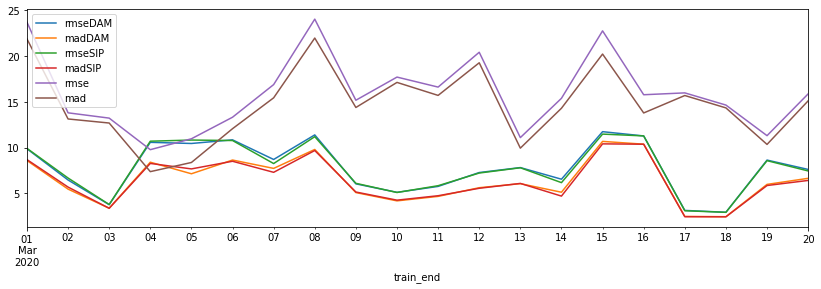

In [11]:
errdf = errdf_dam.merge(errdf_sip, how="inner", on="train_end", suffixes=["DAM", "SIP"])
errdf = errdf.merge(errdf_tod, how="inner", on="train_end", )
display(errdf.mean())
errdf.plot(x="train_end", figsize=[14, 4])

<span style="color:blue">
    
## Observations from the simple model

It appears that adding the simple features from the past day for DAM improve the model

It does not seem that adding the simple features for SIP improves the model DAM prediction.
    
    
## Other things to try
    
* It might be worth looking at where the errors are intra-day  
* Perhaps a forecast horizon of less than a day is interesting  
* I just used some simple, easy to derive features, more complex features might give a better fit  
* A non-linear model might be worth trying  
* A NN might be worth trying as it might infer relvant features  

</span>